In [1]:
# ! pip install yfinance
# ! pip install scikit-learn
# ! pip install requests beautifulsoup4 pandas
# ! pip install lxml
# ! pip install seaborn



In [1]:
# =========================
# Part 1 — 抓取并保存原始历史净值（东财）
# =========================
import re
import time
import requests
import pandas as pd
from html import unescape
from io import StringIO

def fetch_fund_history(code: str, per: int = 20, sleep_s: float = 0.6) -> pd.DataFrame:
    """
    从天天基金抓取历史净值；自动翻页、合并；对网络/解析做稳健处理。
    返回列：['date','unit_nav','cum_nav','daily_rate','purchase','redeem','dividend']
    """
    page, total_pages = 1, None
    all_dfs = []

    while True:
        url = f"https://fundf10.eastmoney.com/F10DataApi.aspx?type=lsjz&code={code}&page={page}&per={per}"
        r = requests.get(url, timeout=10)
        r.encoding = "utf-8"

        m = re.search(r'content:"(.*?)",records', r.text)
        if not m:
            break
        html_str = unescape(m.group(1))
        dfs = pd.read_html(StringIO(html_str))
        if dfs:
            all_dfs.append(dfs[0])

        if total_pages is None:
            pm = re.search(r'pages:(\d+)', r.text)
            total_pages = int(pm.group(1)) if pm else page

        if page >= total_pages:
            break
        page += 1
        time.sleep(sleep_s)

    if not all_dfs:
        raise ValueError("未抓取到任何数据，请检查基金代码或网络。")

    df = pd.concat(all_dfs, ignore_index=True)
    df.columns = ['date', 'unit_nav', 'cum_nav', 'daily_rate', 'purchase', 'redeem', 'dividend']
    return df

if __name__ == "__main__":
    FUND_CODE = "007844"
    RAW_SAVE = f"/workspace/input/{FUND_CODE}_history_raw.csv"

    raw_df = fetch_fund_history(FUND_CODE, per=50)
    raw_df.to_csv(RAW_SAVE, index=False, encoding="utf-8-sig")
    print(f"[OK] 抓取完成，保存：{RAW_SAVE}（{len(raw_df)} 行）")


[OK] 抓取完成，保存：/workspace/input/007844_history_raw.csv（1368 行）


In [2]:
# =========================
# Part 2 — 清洗与基础校验
# =========================
import pandas as pd
from pathlib import Path

FUND_CODE = "007844"
RAW_PATH = Path(f"/workspace/input/{FUND_CODE}_history_raw.csv")
CLEAN_PATH = Path(f"/workspace/input/{FUND_CODE}_history_cleaned.csv")

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 统一列名（若 Part 1 已设，则这步等幂）
    df.columns = ['date', 'unit_nav', 'cum_nav', 'daily_rate', 'purchase', 'redeem', 'dividend']

    # 字段转换
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['unit_nav'] = pd.to_numeric(df['unit_nav'], errors='coerce')
    df['cum_nav'] = pd.to_numeric(df['cum_nav'], errors='coerce')
    df['daily_rate'] = pd.to_numeric(df['daily_rate'].astype(str).str.strip('%'), errors='coerce') / 100.0

    # 排序 & 去重
    df = df.dropna(subset=['date']).sort_values('date').drop_duplicates(subset=['date'])

    # 丢弃无用列（申购/赎回状态、分红文本等）
    df = df.drop(columns=['purchase', 'redeem', 'dividend'], errors='ignore')

    # 少数基金会出现 unit_nav==cum_nav，一般保留 unit_nav
    if 'cum_nav' in df.columns:
        df = df.drop(columns=['cum_nav'])

    # 基础校验
    df = df.dropna(subset=['unit_nav'])
    if len(df) < 100:
        print(f"[WARN] 数据行数偏少：{len(df)}")

    return df.reset_index(drop=True)

if __name__ == "__main__":
    df_raw = pd.read_csv(RAW_PATH)
    df_clean = clean_data(df_raw)
    df_clean.to_csv(CLEAN_PATH, index=False, encoding="utf-8-sig")
    print(f"[OK] 清洗完成：{CLEAN_PATH}（{len(df_clean)} 行）")


[OK] 清洗完成：/workspace/input/007844_history_cleaned.csv（1368 行）


In [3]:
# =========================
# Part 3 — 特征工程与标签构建（避免泄漏）
#   - 仅使用 t 及之前的信息预测 t+1（1日超前）
#   - 额外提供 5日超前标签用于“未来一周趋势”
# =========================
import numpy as np
import pandas as pd
from pathlib import Path

FUND_CODE = "007844"
CLEAN_PATH = Path(f"/workspace/input/{FUND_CODE}_history_cleaned.csv")
FEAT_PATH = Path(f"/workspace/input/{FUND_CODE}_features.csv")

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # 基础收益
    df['ret1'] = df['unit_nav'].pct_change()

    # 移动均线（价格类特征两边不居中，保证仅用历史）
    for w in [3, 5, 7, 10, 20]:
        df[f'sma_{w}'] = df['unit_nav'].rolling(w, min_periods=1).mean()
    # 波动率（过去窗口）
    for w in [3, 5, 10, 20]:
        df[f'vol_{w}'] = df['ret1'].rolling(w, min_periods=2).std()

    # 动量/摆动指标
    df['mom_5'] = df['unit_nav'].pct_change(5)
    # RSI(14) 简易实现
    delta = df['unit_nav'].diff()
    gain = (delta.where(delta > 0, 0.0)).rolling(14, min_periods=14).mean()
    loss = (-delta.where(delta < 0, 0.0)).rolling(14, min_periods=14).mean()
    rs = gain / (loss.replace(0, np.nan))
    df['rsi_14'] = 100 - (100 / (1 + rs))

    # MACD（12,26,9）
    ema12 = df['unit_nav'].ewm(span=12, adjust=False).mean()
    ema26 = df['unit_nav'].ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()
    df['macd'] = macd
    df['macd_sig'] = signal
    df['macd_hist'] = df['macd'] - df['macd_sig']

    # 布林带（20）
    ma20 = df['unit_nav'].rolling(20, min_periods=20).mean()
    std20 = df['unit_nav'].rolling(20, min_periods=20).std()
    df['bb_upper'] = ma20 + 2 * std20
    df['bb_lower'] = ma20 - 2 * std20
    df['bb_pct']   = (df['unit_nav'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])

    # 标签构建：下一交易日与未来5日方向（>0 为 1）
    df['target_1d'] = (df['ret1'].shift(-1) > 0).astype(int)
    df['ret5'] = df['unit_nav'].pct_change(5)
    df['target_5d'] = (df['unit_nav'].shift(-5).pct_change(5).shift(5) < 0)  # 占位避免误解
    # 上式不好读，改为直接未来5日收益方向
    df['ret_fwd_5'] = df['unit_nav'].shift(-5) / df['unit_nav'] - 1.0
    df['target_5d'] = (df['ret_fwd_5'] > 0).astype(int)

    # 丢弃首尾不可用样本（确保无未来信息泄漏）
    df = df.dropna().reset_index(drop=True)
    return df

if __name__ == "__main__":
    base = pd.read_csv(CLEAN_PATH, parse_dates=['date'])
    feat = add_features(base)
    feat.to_csv(FEAT_PATH, index=False, encoding="utf-8-sig")
    print(f"[OK] 特征完成：{FEAT_PATH}（{len(feat)} 行, 列数={feat.shape[1]}）")


[OK] 特征完成：/workspace/input/007844_features.csv（1344 行, 列数=25）


/tmp/ipykernel_7140/2850041734.py:54: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['target_5d'] = (df['unit_nav'].shift(-5).pct_change(5).shift(5) < 0)  # 占位避免误解


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] logreg best score=0.4896, params={'clf__C': 0.5}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] rf best score=0.5201, params={'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}
[SELECT] 选择模型：rf（CV balanced_acc=0.5201）

[TEST] balanced_accuracy=0.4813

              precision    recall  f1-score   support

           0     0.4815    0.4851    0.4833       134
           1     0.4812    0.4776    0.4794       134

    accuracy                         0.4813       268
   macro avg     0.4813    0.4813    0.4813       268
weighted avg     0.4813    0.4813    0.4813       268



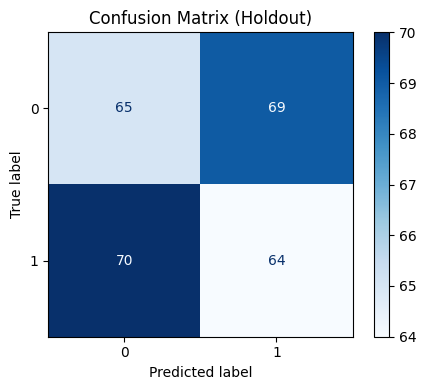

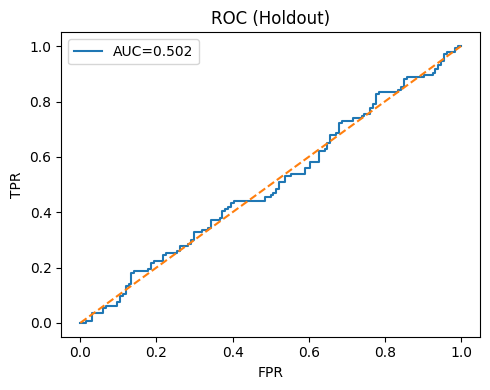

[OK] 测试集预测已保存：/workspace/input/007844_holdout_predictions.csv


In [4]:
# =========================
# Part 4 — 正确的时序验证 + 模型选择 + 指标绘图
#   - 使用 TimeSeriesSplit（扩展窗口）
#   - Pipeline(Scaler + Classifier) 防止泄漏
#   - GridSearchCV 以 balanced_accuracy 评分
#   - 最后留出最近 20% 作为最终检验集
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_auc_score, roc_curve,
                             balanced_accuracy_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

FUND_CODE = "007844"
FEAT_PATH = Path(f"/workspace/input/{FUND_CODE}_features.csv")
REPORT_DIR = Path("/workspace/input"); REPORT_DIR.mkdir(parents=True, exist_ok=True)

# 选择特征列（全部历史可用、不会用到未来）
FEATURES = [
    'sma_3','sma_5','sma_7','sma_10','sma_20',
    'vol_3','vol_5','vol_10','vol_20',
    'mom_5','rsi_14','macd','macd_sig','macd_hist',
    'bb_pct'
]
TARGET = 'target_1d'  # 也可以切换为 'target_5d' 做一周趋势分类

df = pd.read_csv(FEAT_PATH, parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)

# 留出法：最后 20% 作为最终测试集
test_size = max(200, int(len(df) * 0.2))
train_df, test_df = df.iloc[:-test_size], df.iloc[-test_size:]

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_test,  y_test  = test_df[FEATURES],  test_df[TARGET]

# Pipeline + 参数搜索（两类模型做对比）
pipelines = {
    "logreg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, class_weight='balanced', n_jobs=None, solver="lbfgs"))
    ]),
    "rf": Pipeline([
        ("scaler", StandardScaler(with_mean=False)),  # 对树模型可不标化；这里保持一致性
        ("clf", RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
    ])
}

param_grid = {
    "logreg": {
        "clf__C": [0.1, 0.5, 1.0, 2.0]
    },
    "rf": {
        "clf__n_estimators": [200, 400],
        "clf__max_depth": [None, 5, 8, 12],
        "clf__min_samples_leaf": [1, 3, 5]
    }
}

tscv = TimeSeriesSplit(n_splits=5)

best_model = None
best_name = None
best_score = -np.inf

for name, pipe in pipelines.items():
    gscv = GridSearchCV(
        pipe,
        param_grid[name],
        scoring="balanced_accuracy",
        cv=tscv,
        n_jobs=-1,
        verbose=1
    )
    gscv.fit(X_train, y_train)
    print(f"[CV] {name} best score={gscv.best_score_:.4f}, params={gscv.best_params_}")
    if gscv.best_score_ > best_score:
        best_score = gscv.best_score_
        best_model = gscv.best_estimator_
        best_name = name

print(f"[SELECT] 选择模型：{best_name}（CV balanced_acc={best_score:.4f}）")

# 在最终测试集评估
y_pred = best_model.predict(X_test)
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)[:, 1]
else:
    # Fallback：无概率时使用决策函数映射到[0,1]
    dec = best_model.decision_function(X_test)
    y_proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)

bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\n[TEST] balanced_accuracy={bal_acc:.4f}\n")
print(classification_report(y_test, y_pred, digits=4))

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, cmap="Blues", values_format='d')
plt.title("Confusion Matrix (Holdout)")
plt.tight_layout()
plt.show()

# ROC
try:
    auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (Holdout)")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("[WARN] 无法计算ROC：", e)

# 保存测试集预测
pred_out = test_df[['date','unit_nav']].copy()
pred_out['y_true'] = y_test.values
pred_out['y_pred'] = y_pred
pred_out['proba_up'] = y_proba
pred_out['signal'] = np.where(pred_out['y_pred']==1, 'buy', 'sell')
SAVE_PRED = REPORT_DIR / f"{FUND_CODE}_holdout_predictions.csv"
pred_out.to_csv(SAVE_PRED, index=False, encoding="utf-8-sig")
print(f"[OK] 测试集预测已保存：{SAVE_PRED}")


[TRAIN] 1D 模型CV balanced_acc=0.5169
[NEXT-DAY] 预测信号：SELL，上涨概率=0.429
[TRAIN] 5D 模型CV balanced_acc=0.5519
[WEEK] 一周趋势：UP_5D，上涨概率=0.683


/tmp/ipykernel_7140/855160597.py:104: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7140/855160597.py:104: UserWarning: Glyph 36817 (\N{CJK UNIFIED IDEOGRAPH-8FD1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7140/855160597.py:104: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7140/855160597.py:104: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7140/855160597.py:104: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7140/855160597.py:104: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_7140/855160597.py:104: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}

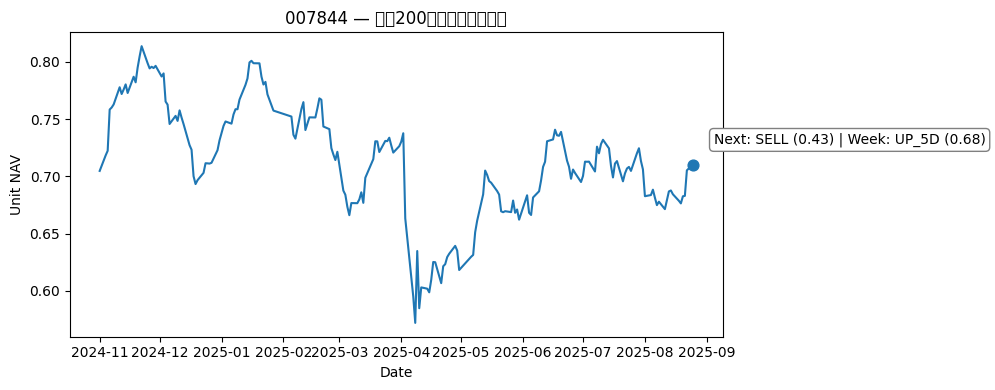

[OK] 未来信号已保存：/workspace/input/007844_future_signals.csv


In [5]:
# =========================
# Part 5 — 训练全量模型并生成“下一日”与“未来一周趋势”预测 + 可视化
#   - 下一日：用 target_1d 模型
#   - 一周趋势：单独训练 target_5d 模型（预测未来5日总体方向）
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

FUND_CODE = "007844"
FEAT_PATH = Path(f"/workspace/input/{FUND_CODE}_features.csv")
OUT_DIR = Path("/workspace/input"); OUT_DIR.mkdir(parents=True, exist_ok=True)

FEATURES = [
    'sma_3','sma_5','sma_7','sma_10','sma_20',
    'vol_3','vol_5','vol_10','vol_20',
    'mom_5','rsi_14','macd','macd_sig','macd_hist',
    'bb_pct'
]

df = pd.read_csv(FEAT_PATH, parse_dates=['date'])
df = df.sort_values('date').reset_index(drop=True)

def train_best(X, y):
    pipelines = {
        "logreg": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=500, class_weight='balanced'))
        ]),
        "rf": Pipeline([
            ("scaler", StandardScaler(with_mean=False)),
            ("clf", RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
        ])
    }
    grid = {
        "logreg": {"clf__C":[0.1,0.5,1.0,2.0]},
        "rf": {"clf__n_estimators":[300,500],
               "clf__max_depth":[None,8,12],
               "clf__min_samples_leaf":[1,3,5]}
    }
    tscv = TimeSeriesSplit(n_splits=5)
    best_est, best_score = None, -np.inf
    for name, pipe in pipelines.items():
        g = GridSearchCV(pipe, grid[name], scoring="balanced_accuracy", cv=tscv, n_jobs=-1, verbose=0)
        g.fit(X, y)
        if g.best_score_ > best_score:
            best_score, best_est = g.best_score_, g.best_estimator_
    return best_est, best_score

# —— 模型A：预测下一日方向 ——
df1 = df.dropna(subset=FEATURES + ['target_1d']).copy()
X1, y1 = df1[FEATURES], df1['target_1d']
model_1d, cv_score_1d = train_best(X1, y1)
print(f"[TRAIN] 1D 模型CV balanced_acc={cv_score_1d:.4f}")

# 下一日预测（基于最后一行）
last_row = df1.iloc[[-1]][FEATURES]
proba_next = model_1d.predict_proba(last_row)[:,1][0] if hasattr(model_1d, "predict_proba") else None
pred_next = model_1d.predict(last_row)[0]
signal_next = 'BUY' if pred_next==1 else 'SELL'
print(f"[NEXT-DAY] 预测信号：{signal_next}，上涨概率={proba_next:.3f}" if proba_next is not None else f"[NEXT-DAY] 预测信号：{signal_next}")

# —— 模型B：预测“未来5日整体趋势” ——
df5 = df.dropna(subset=FEATURES + ['target_5d']).copy()
X5, y5 = df5[FEATURES], df5['target_5d']
model_5d, cv_score_5d = train_best(X5, y5)
print(f"[TRAIN] 5D 模型CV balanced_acc={cv_score_5d:.4f}")

last_row5 = df5.iloc[[-1]][FEATURES]
proba_5d = model_5d.predict_proba(last_row5)[:,1][0] if hasattr(model_5d, "predict_proba") else None
pred_5d = model_5d.predict(last_row5)[0]
signal_5d = 'UP_5D' if pred_5d==1 else 'DOWN_5D'
print(f"[WEEK] 一周趋势：{signal_5d}，上涨概率={proba_5d:.3f}" if proba_5d is not None else f"[WEEK] 一周趋势：{signal_5d}")

# —— 可视化：最近 200 个交易日 + 下一日 & 一周趋势提示 ——
tail_n = 200
plot_df = df.tail(tail_n).copy()
plt.figure(figsize=(10,4))
plt.plot(plot_df['date'], plot_df['unit_nav'], label='Unit NAV')
plt.title(f"{FUND_CODE} — 最近{tail_n}日净值与未来信号")
plt.xlabel("Date"); plt.ylabel("Unit NAV")

# 标注下一日和一周趋势（在最后一点上方）
x_last = plot_df['date'].iloc[-1]
y_last = plot_df['unit_nav'].iloc[-1]
txt = f"Next: {signal_next}"
if proba_next is not None:
    txt += f" ({proba_next:.2f})"
txt += f" | Week: {signal_5d}"
if proba_5d is not None:
    txt += f" ({proba_5d:.2f})"
plt.scatter([x_last],[y_last], s=60)
plt.annotate(txt, (x_last, y_last), xytext=(15, 15), textcoords="offset points",
             bbox=dict(boxstyle="round,pad=0.3", fc="w", ec="gray"))

plt.tight_layout()
plt.show()

# —— 保存结果
out = {
    "next_day_signal": signal_next,
    "next_day_prob_up": float(proba_next) if proba_next is not None else None,
    "week_trend_signal": signal_5d,
    "week_prob_up": float(proba_5d) if proba_5d is not None else None,
    "asof": str(df['date'].iloc[-1].date())
}
pd.DataFrame([out]).to_csv(OUT_DIR / f"{FUND_CODE}_future_signals.csv", index=False, encoding="utf-8-sig")
print(f"[OK] 未来信号已保存：{OUT_DIR / f'{FUND_CODE}_future_signals.csv'}")


In [6]:
# =========================
# Part 6 — 生成带交易信号的回测视图（可选增强）
#   - 基于最佳 1D 模型在整段数据上滚动预测（严格用历史训练）
#   - 与 Buy&Hold 对比累计收益曲线
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.base import clone
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

FUND_CODE = "007844"
FEAT_PATH = Path(f"/workspace/input/{FUND_CODE}_features.csv")
OUT_DIR = Path("/workspace/input"); OUT_DIR.mkdir(parents=True, exist_ok=True)

FEATURES = [
    'sma_3','sma_5','sma_7','sma_10','sma_20',
    'vol_3','vol_5','vol_10','vol_20',
    'mom_5','rsi_14','macd','macd_sig','macd_hist',
    'bb_pct'
]

df = pd.read_csv(FEAT_PATH, parse_dates=['date']).sort_values('date').reset_index(drop=True)

# 基模型（与 Part 5 保持一致）
base_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, class_weight='balanced'))
])

# 滚动预测（walk-forward）：前 i 天训练 -> 预测 i+1 天
df = df.dropna(subset=FEATURES + ['target_1d','ret1']).copy()
preds = []
min_train = 250  # 至少用约1年数据起步
for i in range(min_train, len(df)-1):
    train = df.iloc[:i]
    test_row = df.iloc[[i]]

    model = clone(base_pipeline)
    model.fit(train[FEATURES], train['target_1d'])
    proba_up = model.predict_proba(test_row[FEATURES])[:,1][0]
    pred = 1 if proba_up >= 0.5 else 0
    preds.append((df.loc[i,'date'], pred, proba_up))

wf = pd.DataFrame(preds, columns=['date','pred','proba_up'])
merged = df.merge(wf, on='date', how='left')

# 策略：pred==1 持有，否则持币（不考虑交易成本）
merged['ret_strategy'] = merged['ret1'] * merged['pred'].shift(1)  # 用前一日信号在当日持仓
merged['ret_bh'] = merged['ret1']

merged[['cum_strategy','cum_bh']] = (1+merged[['ret_strategy','ret_bh']]).fillna(1.0).cumprod()

# 画累计收益
plt.figure(figsize=(10,4))
plt.plot(merged['date'], merged['cum_bh'], label='Buy & Hold')
plt.plot(merged['date'], merged['cum_strategy'], label='Strategy (WF)')
plt.title(f"{FUND_CODE} 策略回测（滚动训练，未计费）")
plt.xlabel("Date"); plt.ylabel("Cumulative Return (×)")
plt.legend()
plt.tight_layout()
plt.show()

# 保存
save_bt = OUT_DIR / f"{FUND_CODE}_walkforward_backtest.csv"
merged[['date','unit_nav','ret1','pred','proba_up','ret_strategy','ret_bh','cum_strategy','cum_bh']].to_csv(
    save_bt, index=False, encoding="utf-8-sig"
)
print(f"[OK] 滚动回测结果已保存：{save_bt}")
